此份数据的字段含义

|字段名|中文含义|
|:--:|:--:|
|ID|客户编号|
|Suc_flag|成功入网标识|
|ARPU|入网后ARPU|
|PromCnt12|12个月内的营销次数|
|PromCnt36|36个月内的营销次数|
|PromCntMsg12|12个月内发短信的次数|
|PromCntMsg36|36个月内发短信的次数|
|Class|客户重要性等级(根据前运营商消费情况)|
|Age|年龄|
|Gender|性别|
|HomeOwner|是否拥有住房|
|AvgARPU|当地平均ARPU(每月用户平均收入)|
|AvgHomeValue|当地房屋均价|
|AvgIncome|当地人均收入|

### 本次预测Suc_flg，是否成功入网，可见是二分类问题

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [54]:
telecom = pd.read_csv('teleco_camp.csv', skipinitialspace=True)
telecom.head()

,ID,Suc_flag,ARPU,PromCnt12,PromCnt36,PromCntMsg12,PromCntMsg36,Class,Age,Gender,HomeOwner,AvgARPU,AvgHomeValue,AvgIncome
0,12,1,50.0,5.65,9.50,1.6,3.0,4,79.0,M,H,49.894904,33400,39460
1,53,0,NaN,4.50,9.00,1.4,3.6,3,71.0,M,H,48.574742,37600,33545
2,67,1,25.0,6.40,11.00,2.0,3.6,1,79.0,F,H,49.272646,100400,42091
3,71,1,80.0,7.15,10.25,2.4,3.6,1,63.0,F,H,47.334953,39900,39313
4,142,1,15.0,5.90,10.50,2.0,3.8,1,NaN,F,U,47.827404,47500,0


In [55]:
print(telecom.dtypes)
telecom.describe(include='all')

ID                int64
Suc_flag          int64
ARPU            float64
PromCnt12       float64
PromCnt36       float64
PromCntMsg12    float64
PromCntMsg36    float64
Class             int64
Age             float64
Gender           object
HomeOwner        object
AvgARPU         float64
AvgHomeValue      int64
AvgIncome         int64
dtype: object


,ID,Suc_flag,ARPU,PromCnt12,PromCnt36,PromCntMsg12,PromCntMsg36,Class,Age,Gender,HomeOwner,AvgARPU,AvgHomeValue,AvgIncome
count,9686.000000,9686.000000,4843.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,7279.000000,9686,9686,9686.000000,9686.000000,9686.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,H,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5223,5377,NaN,NaN,NaN
mean,97975.474086,0.500000,78.121722,3.447212,7.337059,1.178402,2.390935,2.424530,59.150845,NaN,NaN,52.905156,110986.299814,40491.444249
std,56550.171120,0.500026,62.225686,1.231890,1.952436,0.287226,0.914314,1.049047,16.516400,NaN,NaN,4.993775,98670.855450,28707.494146
min,12.000000,0.000000,5.000000,0.750000,1.000000,0.200000,0.400000,1.000000,0.000000,NaN,NaN,46.138968,0.000000,0.000000
25%,48835.500000,0.000000,50.000000,2.900000,6.250000,1.000000,1.400000,2.000000,47.000000,NaN,NaN,49.760116,52300.000000,24464.000000
50%,99106.000000,0.500000,65.000000,3.250000,7.750000,1.200000,2.600000,2.000000,60.000000,NaN,NaN,50.876672,76900.000000,43100.000000
75%,148538.750000,1.000000,100.000000,3.650000,8.250000,1.400000,3.200000,3.000000,73.000000,NaN,NaN,54.452822,128175.000000,56876.000000


通过describe可以发现一些内容：

- 数据应该是9686条
- ARPU和age列存在缺失数据，需要进行填补
- Gneder存在错误数据，出现了第三种性别
- Age、AvgIncome、AvgHomeValue最小值是0，这个是不合理的
- Gender和HomeOwner都是字符，机器不认，需要进行编码处理

### 数据清洗

- 对字符进行编码处理

In [56]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
telecom['Gender'] = le.fit_transform(telecom['Gender'])
telecom['HomeOwner'] = le.fit_transform(telecom['HomeOwner'])
telecom['HomeOwner'].head(20)

0     0
1     0
2     0
3     0
4     1
5     1
6     1
7     0
8     0
9     1
10    0
11    1
12    1
13    0
14    0
15    1
16    0
17    0
18    1
19    1
Name: HomeOwner, dtype: int64

- 处理错误值，即'AvgIncome', 'Age', 'AvgHomeValue'中的0

In [57]:
for col in ['AvgIncome', 'Age', 'AvgHomeValue']:
    telecom[col].replace({0: np.NaN}, inplace=True)  #将0替换为NaN， inplace=True表示替换数据自身

telecom[['ID','AvgIncome', 'Age', 'AvgHomeValue']].describe(include='all')

,ID,AvgIncome,Age,AvgHomeValue
count,9686.000000,7329.000000,7278.000000,9583.000000
mean,97975.474086,53513.457361,59.158972,112179.202755
std,56550.171120,19805.168339,16.502972,98522.888583
min,12.000000,2499.000000,2.000000,7500.000000
25%,48835.500000,40389.000000,47.000000,53200.000000
50%,99106.000000,48699.000000,60.000000,77700.000000
75%,148538.750000,62385.000000,73.000000,129350.000000
max,191779.000000,200001.000000,87.000000,600000.000000


- 处理缺失值（之前已经把错误值转换为NaN，现在就是用均值填补NaN）

In [58]:
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
telecom1 = pd.DataFrame(imputer.fit_transform(telecom), columns=telecom.columns)
telecom1.describe(include='all')

,ID,Suc_flag,ARPU,PromCnt12,PromCnt36,PromCntMsg12,PromCntMsg36,Class,Age,Gender,HomeOwner,AvgARPU,AvgHomeValue,AvgIncome
count,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000
mean,97975.474086,0.500000,78.121722,3.447212,7.337059,1.178402,2.390935,2.424530,59.158972,0.516312,0.444869,52.905156,112179.202755,53513.457361
std,56550.171120,0.500026,43.997933,1.231890,1.952436,0.287226,0.914314,1.049047,14.305022,0.600716,0.496977,4.993775,97997.592632,17227.468161
min,12.000000,0.000000,5.000000,0.750000,1.000000,0.200000,0.400000,1.000000,2.000000,0.000000,0.000000,46.138968,7500.000000,2499.000000
25%,48835.500000,0.000000,65.000000,2.900000,6.250000,1.000000,1.400000,2.000000,51.000000,0.000000,0.000000,49.760116,53500.000000,42775.000000
50%,99106.000000,0.500000,78.121722,3.250000,7.750000,1.200000,2.600000,2.000000,59.158972,0.000000,0.000000,50.876672,78450.000000,53513.457361
75%,148538.750000,1.000000,78.121722,3.650000,8.250000,1.400000,3.200000,3.000000,69.000000,1.000000,1.000000,54.452822,128175.000000,56876.000000
max,191779.000000,1.000000,1000.000000,15.150000,19.500000,3.600000,5.600000,4.000000,87.000000,2.000000,1.000000,99.444787,600000.000000,200001.000000


In [60]:
# 在性别里面，出现了2.0，可能表示未知，此处暂时不处理
telecom1.groupby(['Gender'])['ID'].count()

# 或使用0.0填补
# telecom1['Gender'].replace({2.0: 0.0}, inplace=True)
# telecom1.groupby(['Gender'])['ID'].count()

Gender
0.0    5223
1.0    3925
2.0     538
Name: ID, dtype: int64

- 极端值处理（前1% 后1%），演示一下怎么处理，其实并不需要

In [ ]:
def blk(floor, root):   #floor最小值， root最大值
    def f(x):
        if x < floor:
            x = floor
        elif x > root:
            x = root
        return x
    return f
# blk返回函数f
q1 = telecom1['Age'].quantile(0.01)
q99 = telecom1['Age'].quantile(0.99)
blk_tot = blk(floor=q1, root=q99)
telecom1['Age'] = telecom1['Age'].map(blk_tot)
# 此处为什么一定要从函数中返回函数呢？
# 因为map函数里面的函数只能接受一个参数的传入，
# 这个参数也就是telecom['Age]里每个元素，但是同时又需要上下限
# 此时python这种函数式编程（返回函数）就能派上用场
# 返回的函数已经将一部分参数写进去了 

In [61]:
telecom1.describe()

,ID,Suc_flag,ARPU,PromCnt12,PromCnt36,PromCntMsg12,PromCntMsg36,Class,Age,Gender,HomeOwner,AvgARPU,AvgHomeValue,AvgIncome
count,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000
mean,97975.474086,0.500000,78.121722,3.447212,7.337059,1.178402,2.390935,2.424530,59.158972,0.516312,0.444869,52.905156,112179.202755,53513.457361
std,56550.171120,0.500026,43.997933,1.231890,1.952436,0.287226,0.914314,1.049047,14.305022,0.600716,0.496977,4.993775,97997.592632,17227.468161
min,12.000000,0.000000,5.000000,0.750000,1.000000,0.200000,0.400000,1.000000,2.000000,0.000000,0.000000,46.138968,7500.000000,2499.000000
25%,48835.500000,0.000000,65.000000,2.900000,6.250000,1.000000,1.400000,2.000000,51.000000,0.000000,0.000000,49.760116,53500.000000,42775.000000
50%,99106.000000,0.500000,78.121722,3.250000,7.750000,1.200000,2.600000,2.000000,59.158972,0.000000,0.000000,50.876672,78450.000000,53513.457361
75%,148538.750000,1.000000,78.121722,3.650000,8.250000,1.400000,3.200000,3.000000,69.000000,1.000000,1.000000,54.452822,128175.000000,56876.000000
max,191779.000000,1.000000,1000.000000,15.150000,19.500000,3.600000,5.600000,4.000000,87.000000,2.000000,1.000000,99.444787,600000.000000,200001.000000


### 变量筛选

- 使用随机森林分类器返回变量的重要性

In [81]:
from sklearn import ensemble

X = telecom1.loc[:, 'ARPU':]
y = telecom1['Suc_flag']

crf = ensemble.RandomForestClassifier()

crf.fit(X=X, y=y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

- 随机森林分类器返回的是每个变量的重要性

In [68]:
crf.feature_importances_

array([6.06946799e-01, 1.67940718e-01, 2.20459161e-02, 1.57449022e-01,
       1.57554585e-02, 4.40238811e-03, 3.68967293e-03, 9.15724247e-04,
       3.98958214e-04, 1.14433848e-02, 4.80922590e-03, 4.20273102e-03])

In [75]:
pd.Series(data=X.columns, index=crf.feature_importances_).sort_index(ascending=False)

0.709375            ARPU
0.164053    PromCntMsg12
0.062107       PromCnt12
0.019746    PromCntMsg36
0.017322       PromCnt36
0.009585         AvgARPU
0.005692           Class
0.004198    AvgHomeValue
0.004098             Age
0.002550       AvgIncome
0.000976          Gender
0.000299       HomeOwner
dtype: object

- 使用IV值对变量进行筛选（可以反映整个变量“分类”能力的强弱，IV越大，说明该变量的分类能力越强，这个变量在模型中越重要）

In [78]:
X['AvgHomeValue'].unique()

array([ 33400.,  37600., 100400., ..., 228800., 566700., 165200.])

- IV 计算函数（IVi = (P1 - P0)*woe）

In [85]:
# 定义IV计算函数
def IV_between(y, x):   #y 和 x 都是Series类型
    all_i = y.groupby(x).count()
    bad_i = y.groupby(x).sum()     #Suc里只有0和1， 1表示成功入网
    good_i = all_i - bad_i
#   计算正例水平
    p1 = bad_i / bad_i.sum()
#   计算负例水平
    p0 = good_i / good_i.sum()
    
    woe = np.log((p1 + 1e-5) / (p0 + 1e-5))
    
    IV = (p1 - p0) * woe
    
    return IV.sum()

In [86]:
IV = pd.Series()

for i in X.columns:
    if len(X[i].unique()) > 10 and X[i].dtype != np.object:
        try:
            tmp = pd.qcut(X[i], 5)   #等分离散（按照相同的百分比分成五分）
        except:
            tmp = pd.cut(X[i], 5)   #等宽离散（按照相同的间隔分成五分）
        IV = IV.append(pd.Series([i], index=[IV_between(y=y, x=tmp)]))
    else:
        IV = IV.append(pd.Series([i], index=[IV_between(y=y, x=tmp)]))
    
sort_IV = IV.sort_index(ascending=False)
sort_IV

0.479255       PromCnt12
0.326262    PromCntMsg12
0.211120            ARPU
0.032807         AvgARPU
0.031443    PromCntMsg36
0.031443           Class
0.016009       PromCnt36
0.014777    AvgHomeValue
0.011867             Age
0.011867          Gender
0.011867       HomeOwner
0.004153       AvgIncome
dtype: object

In [104]:
# 使用前八个变量作为筛选后的变量
select_features = ['Suc_flag']
select_features.extend(sort_IV.iloc[:8])
telecom2 = telecom1[select_features]
print(telecom2.dtypes)
telecom2.sample(5)

Suc_flag        float64
PromCnt12       float64
PromCntMsg12    float64
ARPU            float64
AvgARPU         float64
PromCntMsg36    float64
Class           float64
PromCnt36       float64
AvgHomeValue    float64
dtype: object


,Suc_flag,PromCnt12,PromCntMsg12,ARPU,AvgARPU,PromCntMsg36,Class,PromCnt36,AvgHomeValue
7368,1.0,3.15,1.4,50.0,52.390753,3.0,4.0,7.25,216600.0
732,1.0,7.65,1.4,100.0,50.297212,3.2,4.0,12.00,89600.0
458,1.0,11.65,2.8,55.0,46.862451,4.8,2.0,16.50,55700.0
833,1.0,3.65,1.4,50.0,48.935853,3.0,1.0,8.00,72300.0
6493,1.0,3.40,1.4,25.0,50.014421,2.6,2.0,7.00,71700.0


### 划分训练集和测试集

- 对离散变量进行哑变量变换, 客户等级分为四个1，2，3，4

In [107]:
pd.get_dummies(telecom['Class']).head()

,1,2,3,4
0,0,0,0,1
1,0,0,1,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [119]:
telecom2.join(pd.get_dummies(telecom['Class'])).head()

,Suc_flag,PromCnt12,PromCntMsg12,ARPU,AvgARPU,PromCntMsg36,Class,PromCnt36,AvgHomeValue,1,2,3,4
0,1.0,5.65,1.6,50.000000,49.894904,3.0,4.0,9.50,33400.0,0,0,0,1
1,0.0,4.50,1.4,78.121722,48.574742,3.6,3.0,9.00,37600.0,0,0,1,0
2,1.0,6.40,2.0,25.000000,49.272646,3.6,1.0,11.00,100400.0,1,0,0,0
3,1.0,7.15,2.4,80.000000,47.334953,3.6,1.0,10.25,39900.0,1,0,0,0
4,1.0,5.90,2.0,15.000000,47.827404,3.8,1.0,10.50,47500.0,1,0,0,0


In [113]:
telecom3 = telecom2.join(pd.get_dummies(telecom['Class'])).drop('Class', axis=1)
telecom3.head()

,Suc_flag,PromCnt12,PromCntMsg12,ARPU,AvgARPU,PromCntMsg36,PromCnt36,AvgHomeValue,1,2,3,4
0,1.0,5.65,1.6,50.000000,49.894904,3.0,9.50,33400.0,0,0,0,1
1,0.0,4.50,1.4,78.121722,48.574742,3.6,9.00,37600.0,0,0,1,0
2,1.0,6.40,2.0,25.000000,49.272646,3.6,11.00,100400.0,1,0,0,0
3,1.0,7.15,2.4,80.000000,47.334953,3.6,10.25,39900.0,1,0,0,0
4,1.0,5.90,2.0,15.000000,47.827404,3.8,10.50,47500.0,1,0,0,0


In [132]:
from sklearn.model_selection import train_test_split

data = telecom3.iloc[:, 1:]
target = telecom3['Suc_flag']
train_data, test_data, train_target, test_target = train_test_split(data, target, 
                                                                    test_size=0.4, train_size=0.6, random_state=123)
# 表示训练集占60%，测试集占40%

### 标准化

In [129]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.fit_transform(test_data)

### 建立逻辑回归模型

In [133]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()
logistic_model.fit(scaled_train_data, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### 预测

预测分类标签

In [143]:
train_predict = logistic_model.predict(scaled_train_data)
test_predict = logistic_model.predict(scaled_test_data)
test_predict

array([0., 1., 1., ..., 1., 0., 0.])

In [154]:
train_proba = logistic_model.predict_proba(scaled_train_data)[:,1]  # 计算分别属于各类的概率，取标签为1的概率，第一列是为0的概率，下标从0开始
test_proba = logistic_model.predict_proba(scaled_test_data)[:,1]

### 评估

#### 使用accuracy（准确率）来评估模型

In [150]:
logistic_model.score(scaled_test_data, test_target)

0.768774193548387

混淆矩阵

In [151]:
from sklearn import metrics

print(metrics.confusion_matrix(test_target, test_predict, labels=[0, 1]))  # 混淆矩阵
print(metrics.classification_report(test_target, test_predict))  # 计算评估指标

[[1443  462]
 [ 434 1536]]
             precision    recall  f1-score   support

        0.0       0.77      0.76      0.76      1905
        1.0       0.77      0.78      0.77      1970

avg / total       0.77      0.77      0.77      3875



ROC曲线和AUC评估

AUC = 0.8313


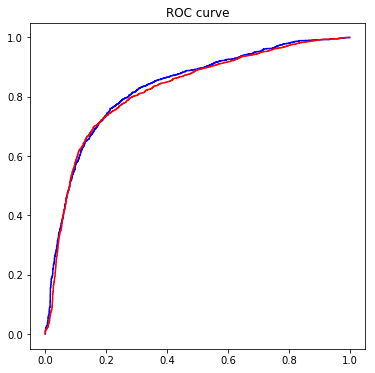

In [157]:
# 分别画出训练和测试集的ROC曲线，看重合度
# 分别计算FPR和TPR

fpr_test, tpr_test, th_test = metrics.roc_curve(test_target, test_proba)
fpr_train, tpr_train, th_train = metrics.roc_curve(train_target, train_proba)

plt.figure(figsize=[6, 6])
plt.plot(fpr_test, tpr_test, 'b-')
plt.plot(fpr_train, tpr_train, 'r-')
plt.title('ROC curve')
print('AUC = %6.4f' %metrics.auc(fpr_test, tpr_test))

## 预测的模型是 logistic_model